In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import re

from sklearn.ensemble import IsolationForest


###########################################
#               FUNCTIONS                 #
###########################################


def clean_reference(ref,outliers):
    for i in outliers:
        ref = ref.drop(labels=i,axis=1)

    return ref

def norm_ref(ref):
    med = ref.median(axis=0)
    norm_ref = ref/med
    return norm_ref, med

def create_synthetic(norm_ref,med,N):
    synt = pd.DataFrame(index=norm_ref.index,columns=range(N))
    for j in range(N):
        for i in norm_ref.index:
            synt[j][i] = np.random.choice(norm_ref.loc[norm_ref.index==i].values.flatten())

        synt[j] = synt[j] * np.random.choice(med)
    synt.columns = ["sample_" + str(i) for i in range(synt.shape[1])]
    return synt

def add_features(synt,sample,gene,factor,exon=None):
    if exon is None:
        pattern = gene
        tmp = [str(synt.index[i]).split("_")[0] for i in range(synt.shape[0])]
        synt.loc[[tmp[i]==pattern for i in range(len(tmp))],sample] = synt.loc[[tmp[i]==pattern for i in range(len(tmp))]][sample] * factor
        
    if exon is not None:
        pattern = gene + "_" + exon
        tmp = [str(synt.index[i]).split("_")[0] + "_" + str(synt.index[i]).split("_")[1] for i in range(synt.shape[0])] 
        synt.loc[[tmp[i]==pattern for i in range(len(tmp))],sample] = synt.loc[[tmp[i]==pattern for i in range(len(tmp))]][sample] * factor
    
    res = synt
    return res


def openJson(path,n):
    """
    Opens json files in path to create a reads matrix
    """
    tmp = os.listdir(path)
    tmp = np.array(tmp)[np.array([bool(re.findall("depths.json$",tmp[i])) for i in range(len(tmp))])]
    reads = np.zeros((n,len(tmp)))
    amplicons = ["" for x in range(n)]
    q=0
    for p in tmp:
        with open(path+p) as json_file:
            data = json.load(json_file)
            for i in range(n):
                amplicons[i] = data[i]['name']
                for j in data[i]['depths']:
                    reads[i,q] = int(data[i]['depths'][j]['min'])
        q=q+1
    reads = pd.DataFrame(data = reads,index=amplicons)
    reads.columns = [i.split('_')[0]+'_'+i.split('_')[1] for i in tmp]
    return reads

def sumLibraries(reads):
    samples = np.unique([i.split('_')[0] for i in reads.columns])
    reads_f = np.zeros((reads.shape[0],len(samples)))
    q=0
    for i in samples:
        sub = reads.filter(regex="^"+i)
        reads_f[:,q] = sub.sum(axis=1)
        q=q+1
    reads_f = pd.DataFrame(data = reads_f,index=reads.index)
    reads_f.columns = list(samples)
    return(reads_f)

def correctIndex(reads,correspondance):
    l = ["" for x in range(len(reads.index))]
    q=0
    for i in reads.index:
        l[q] = i[(len(i)-9):len(i)]
        q=q+1
    final = reads[[correspondance["amplicon"][0] in l[x] for x in range(len(l))]]
    for i in correspondance["amplicon"]:
        if i!=correspondance["amplicon"][0]:
            final = pd.concat([final,reads[[i in l[x] for x in range(len(l))]]])
    final.index = correspondance["gene_exon"] + "_" + correspondance["amplicon"]
    return final


def filterReads(reads,N,output_path):
    reads = reads.loc[:,reads.sum(axis=0)>N]
    reads = reads.filter(regex="^(?!MSI)",axis=0)
    reads = reads.filter(regex="^(?!TN)")
    reads = reads.filter(regex="^(?!TP)")
    reads = reads.filter(regex="^(?!HD)")
    reads = reads.filter(regex="^(?!H2)")
    reads.to_csv(output_path, sep="\t",index=True)
    return(reads)


def normalizeReads(reads,output_path,save=False):
    reads_norm=reads/reads.median(axis=0)
    reads = np.log(reads+1)
    if save==True:
        reads_norm.to_csv(output_path, sep="\t",index=True)
    return(reads_norm)


def aberrantSamples(reads,conta='auto'):
    read = reads.astype("float")
    tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
    random_data = np.array(tmp).reshape(-1,1)

    clf = IsolationForest(contamination=conta).fit(random_data)
    preds = clf.predict(random_data)
    res = np.array(reads.columns)[preds==-1]
    return(res)

def aberrantSamples2(reads):
    read = reads.astype("float")
    tmp = np.percentile(reads, 5, axis = 0)/np.mean(reads, axis = 0)
    random_data = np.array(tmp).reshape(-1,1)

    clf = IsolationForest(contamination=0.1).fit(random_data)
    preds = clf.predict(random_data)
    res = np.array(reads.columns)[preds==-1]
    return(res)


def aberrantAmplicons(reads_norm,abSamples):
    for name in res:
        random_data = np.array(reads_norm[name]).reshape(-1,1)
        clf = IsolationForest(contamination=0.001).fit(np.array(np.mean(reads_norm, axis = 1)).reshape(-1,1))
        preds = clf.predict(random_data)
        print(name)
        print(np.array(reads_norm.index)[preds==-1])

def aberrantAmpliconsPerSample(name,reads_norm,conta='auto',verbose=False):
    random_data = np.array(reads_norm[name]).reshape(-1,1)
    clf = IsolationForest(contamination=conta).fit(np.array(np.mean(reads_norm, axis = 1)).reshape(-1,1))
    preds = clf.predict(random_data)
    if verbose:
        print(name)
        print(np.array(reads_norm.index)[preds==-1])
    return(np.array(reads_norm.index)[preds==-1])


def aberrantAmpliconsPerSample2(name,reads,abSamples,verbose=False):
    ab = [i in abSamples for i in reads.columns]
    normalReads = reads[np.delete(reads.columns,ab)]
    med = np.percentile(normalReads, 99, axis = 1)
    reads = (reads.T/med).T
    random_data = np.array(reads[name]).reshape(-1,1)
    clf = IsolationForest(contamination=0.05).fit(np.array(np.median(reads, axis = 1)).reshape(-1,1))
    preds = clf.predict(random_data)
    if verbose:
        print(name)
        print(np.array(reads.index)[preds==-1])
    return(np.array(reads.index)[preds==-1])



def percentagePerExon(amplified,reads,verbose=False):
    genes = [i.split('_')[0] for i in reads.index]
    exons = [i.split('_')[1] for i in reads.index]
    g_e = [genes[i]+'_'+exons[i] for i in range(len(genes))]
    n_ge = np.array([g_e.count(i) for i in np.unique(g_e)])
    ag = [i.split('_')[0] for i in amplified]
    ae = [i.split('_')[1] for i in amplified]
    age = [ag[i]+'_'+ae[i] for i in range(len(amplified))]
    f = pd.DataFrame(index=np.unique(age),columns=["percentage"])
    f = f.fillna(0)
    for i in range(len(np.unique(age))):
        f['percentage'][i] = 100*float(age.count(''.join(np.unique(age)[i]))/n_ge[np.unique(g_e)==''.join(np.unique(age)[i])])
        if verbose:
            if f['percentage'][i]>50:
                print(np.unique(age)[i] + ": " + str(round(f['percentage'][i]))+'%'+' des amplicons de l\'exon sont aberrants')
    return(f)

def percentagePerGene(amplified,reads,verbose=False):
    genes = [i.split('_')[0] for i in reads.index]
    ag = [i.split('_')[0] for i in amplified]
    n_g = np.array([genes.count(i) for i in np.unique(genes)])
    f = pd.DataFrame(index=np.unique(ag),columns=["percentage"])
    f = f.fillna(0)
    for i in range(len(np.unique(ag))):
        f['percentage'][i] = 100*float(ag.count(''.join(np.unique(ag)[i]))/n_g[np.unique(genes)==''.join(np.unique(ag)[i])])
        if verbose:
            if f['percentage'][i]>50:
                print(np.unique(ag)[i] + ": " + str(round(f['percentage'][i]))+'%'+' des amplicons du gene sont aberrants')
    return(f)

def amplifEvalGene(reads,abSamples,gene,sample):
    reads_m = reads#/reads.median(axis=0)
    reads_m = reads_m.filter(regex="^"+gene,axis=0)
    sub = reads_m
    for i in abSamples:
        sub = sub.drop(labels=i,axis=1)
    reads_m = reads_m[sample]   
    val = np.mean(reads_m)/np.mean(sub.mean())
    if val==np.inf:
        val = 100
    return val

def scoreAmplif(k,n,N):
    p = n/N
    x = np.log(1/((p**k)*(1-p)**(n-k)))*(k/n)
    # score = 1/(1+np.exp(-x))
    score = x/390 + 190/390
    
    return x

def aberrantAmpliconsFinal(reads, reads_norm, abSamples,abSamples2,run,threshold):
    f = pd.DataFrame(columns=["run","name","gene","amplif","score"])
        
    q=0 
    for name in abSamples:
        #abAmp = aberrantAmpliconsPerSample2(name,reads_norm,abSamples,verbose=False)
        abAmp = aberrantAmpliconsPerSample(name,reads_norm,conta=0.05,verbose=False)
        if abAmp.shape!=(0,):
            genes = np.unique([i.split('_')[0] for i in abAmp])
            for gene in genes:
                r = re.compile(gene)
                abEx = list(filter(r.match, abAmp))
                exons1 = [i.split('_')[0]+"_"+i.split('_')[1] for i in abEx]
                tmp = reads.filter(regex="^"+gene,axis=0)
                exons2 = [i.split('_')[0]+"_"+i.split('_')[1] for i in tmp.index]
                
                score = scoreAmplif(len(abEx),tmp.shape[0],reads.shape[0])
                
                amplif = amplifEvalGene(reads, abSamples, gene, name)

                if score>threshold:
                    if amplif>1:
                        f.loc[q] = [run,name,gene,amplif,score]
                        q=q+1
                    #if amplif<1:
                    #    f.loc[q] = [run,name,gene,amplif,score]
                    #    q=q+1

    return(f)


def aberrantAmpliconsFinal2(reads, reads_norm, abSamples,abSamples2,run,threshold):
    f = pd.DataFrame(columns=["run","name","gene","amplif","score"])
        
    q=0 
    for name in abSamples2:
        #abAmp = aberrantAmpliconsPerSample2(name,reads_norm,abSamples,verbose=False)
        abAmp = aberrantAmpliconsPerSample(name,reads_norm,verbose=False)
        if abAmp.shape!=(0,):
            genes = abAmp
            for gene in genes:
                r = re.compile(gene)
                abEx = list(filter(r.match, abAmp))
                #print(abEx)
                tmp = reads.filter(regex="^"+gene,axis=0)                
                score = scoreAmplif(len(abEx),tmp.shape[0],reads.shape[0])
                
                amplif = amplifEvalGene(reads, abSamples, gene, name)

                if score>threshold:
                    if amplif>1:
                        f.loc[q] = [run,name,gene,amplif,score]
                        q=q+1
                    #if amplif<1:
                    #    f.loc[q] = [run,name,gene,amplif,score]
                    #    q=q+1

    return(f)




In [20]:
from tqdm.notebook import tqdm
pd.set_option('display.max_rows', 100)

run = "synt_tsca"
output_path = "/home/scabello/Documents/run_juno/CNV/"

#genes = pd.read_csv("/Users/admin/Documents/CNV/genes_tsca.txt",sep="\t")

synt = pd.read_csv("/home/scabello/Documents/run_juno/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

factor = 0
data = add_features(synt,sample="sample_1",gene = "PDGFRA",factor = factor)
data = add_features(synt,sample="sample_1",gene = "KIT",factor = factor)
data = add_features(data,sample="sample_10",gene = "EGFR",factor = factor)
data = add_features(data,sample="sample_15",gene = "MET",factor = factor)
data = add_features(data,sample="sample_15",gene = "EGFR",factor = factor)
#data = add_features(data,sample="sample_20",gene = "KRAS",factor = factor)

abSamples = aberrantSamples(data)
#abSamples = ["sample_1","sample_10","sample_15"]
print(abSamples)
final_norm = normalizeReads(data,output_path+'/reads_'+run+'_norm2.tsv',save=False)
ff = aberrantAmpliconsFinal(data,final_norm,abSamples,data.columns,run,3)
ff


['sample_5' 'sample_28']


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1475 but corresponding boolean dimension is 32

In [10]:
def aberrantSamples(reads):
    read = reads.astype("float")
    tmp = np.var(reads)/np.mean(reads)
    random_data = np.array(tmp).reshape(-1,1)

    clf = IsolationForest(contamination=0.05).fit(random_data)
    preds = clf.predict(random_data)
    res = np.array(reads.columns)[preds==-1]
    return(res)


def aberrantAmpliconsPerSample(name,reads,verbose=False):
    tmp = np.percentile(reads[name], 1, axis = 0)/np.mean(reads, axis = 0)    
    random_data = np.array(tmp).reshape(-1,1)
    clf = IsolationForest(contamination=0.01).fit(np.array(np.mean(reads, axis = 1)).reshape(-1,1))
    preds = clf.predict(random_data)
    if verbose:
        print(name)
        print(np.array(reads.index)[preds==-1])
    return(np.array(reads.index)[preds==-1])

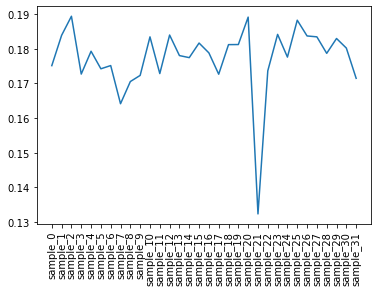

In [218]:
synt = pd.read_csv("/home/scabello/Documents/run_juno/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

n = 1
factor = 0.1
data = add_features(synt,sample="sample_21",gene = "BRCA2",factor = factor)
#data = add_features(data,sample="sample_20",gene = "EGFR",factor = factor)
#data = add_features(data,sample="sample_22",gene = "EGFR",factor = factor)


reads = data
tmp = np.var(reads)/np.mean(reads)
tmp = np.percentile(reads, 10, axis = 0)/np.mean(reads, axis = 0)
random_data = np.array(tmp).reshape(-1,1)
plt.xticks(rotation=90)
plt.plot(tmp)
#for i in range(0,101):
#    clf = IsolationForest(contamination=i/100).fit(random_data)
#    preds = clf.predict(random_data)
# #   abSamples = pd.DataFrame(reads.columns)[preds==-1]
#    abSamples.to_csv("/home/scabello/Documents/run_juno/CNV/seuils/juno/conta/"+"conta_"+str(i)+".tsv", sep="\t",index=False)


['sample_0', 'sample_1', 'sample_2', 'sample_3', 'sample_4']



5: q/100
['sample_0', 'sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_2', 'sample_3', 'sample_4', 'sample_5']


KeyboardInterrupt: 

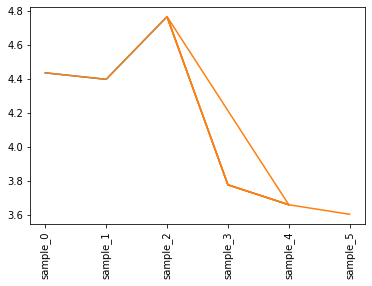

In [42]:
from tqdm.notebook import tqdm
synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

n = 0
factor = 3
data = add_features(synt,sample="sample_0",gene = "EGFR",factor = factor)
data = add_features(data,sample="sample_1",gene = "EGFR",factor = factor)
data = add_features(data,sample="sample_2",gene = "EGFR",factor = factor)
#data = add_features(data,sample="sample_3",gene = "EGFR",factor = factor)
temp = ["sample_0","sample_1"]

for k in range(5,32):

    for N in range(2,k):
        temp.extend(["sample_"+str(N)])
    print(temp)
    reads = data[temp]
    #print(reads.shape)
    q=0

    tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
    plt.xticks(rotation=90)
    plt.plot(tmp)

    for N in tqdm(range(100)):
        tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
        random_data = np.array(tmp).reshape(-1,1)
        #plt.xticks(rotation=90)
        #plt.plot(tmp)
        clf = IsolationForest(contamination=0.1).fit(random_data)
        preds = clf.predict(random_data)
        abSamples = pd.DataFrame(reads.columns)[preds==-1]
        #print(abSamples)
        if sum(np.in1d(abSamples,["sample_0","sample_1","sample_2"]))==3:
            q=q+1
        if sum(np.in1d(abSamples,["sample_0","sample_1","sample_2"]))==2:
            q=q+0.67
        if sum(np.in1d(abSamples,["sample_0","sample_1","sample_2"]))==1:
            q=q+0.33

        #abSamples.to_csv("/home/scabello/Documents/run_juno/CNV/seuils/juno/conta/"+str(k)+".tsv", sep="\t",index=False)


    print(str(k)+": q/100")

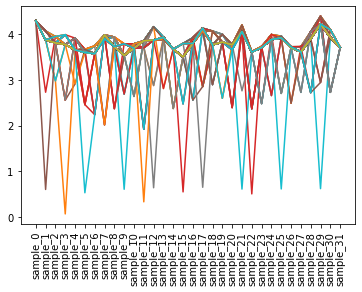

In [4]:
from tqdm.notebook import tqdm


n = 0
factor = 10
gene = "KRAS"
ref = ["sample_"+str(i) for i in range(32)]


for b in tqdm(range(10)):
    tp=[]
    fp=[]
    fn=[]
    tn=[]
    for k in tqdm(range(1,15)):
        #print(k)
        synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)
        reads = add_features(synt,sample="sample_0",gene = gene,factor = factor)
        temp = ["sample_0"]

        tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
        plt.xticks(rotation=90)
        plt.plot(tmp)

        for N in np.random.randint(30,size=k):
            reads = add_features(reads,sample="sample_"+str(N+1),gene = gene,factor = factor)
            temp.extend(["sample_"+str(N+1)])

        neg = np.array(ref)[np.in1d(ref,temp)==False]
        
        #print(temp)
        p=[]
        q=[]
        r=[]
        s=[]
        tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
        plt.xticks(rotation=90)
        plt.plot(tmp)

        for N in (range(20)):
            tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
            random_data = np.array(tmp).reshape(-1,1)
            #plt.xticks(rotation=90)
            #plt.plot(tmp)
            clf = IsolationForest(contamination=0.1).fit(random_data)
            preds = clf.predict(random_data)
            abSamples = pd.DataFrame(reads.columns)[preds==-1]
            ndet = np.array(ref)[np.in1d(ref,abSamples)==False]
            #print(abSamples)
            p.extend([sum(np.in1d(abSamples,temp))])
            q.extend([sum(np.in1d(abSamples,neg))])
            r.extend([sum(np.in1d(ndet,temp))])
            s.extend([sum(np.in1d(ndet,neg))])

        tp.extend([np.mean(p)])
        fp.extend([np.mean(q)])
        fn.extend([np.mean(r)])
        tn.extend([np.mean(s)])


    pd.DataFrame(tp).to_csv("/Users/admin/Documents/CNV/article/conta/tp_"+gene+"_"+str(factor)+"_samples_"+str(b)+".tsv", sep="\t",index=False)
    pd.DataFrame(fp).to_csv("/Users/admin/Documents/CNV/article/conta/fp_"+gene+"_"+str(factor)+"_samples_"+str(b)+".tsv", sep="\t",index=False)
    pd.DataFrame(fn).to_csv("/Users/admin/Documents/CNV/article/conta/fn_"+gene+"_"+str(factor)+"_samples_"+str(b)+".tsv", sep="\t",index=False)
    pd.DataFrame(tn).to_csv("/Users/admin/Documents/CNV/article/conta/tn_"+gene+"_"+str(factor)+"_samples_"+str(b)+".tsv", sep="\t",index=False)


    #print(str(k)+": "+str(q/100))

In [27]:
from tqdm.notebook import tqdm


n = 0
factor = 5
gene = "EGFR"

tp=[]
fp=[]
fn=[]
tn=[]
for b in tqdm(range(2,100)):
    ref = ["sample_"+str(i) for i in range(b)]
    synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw_100.tsv",sep="\t",index_col=0)
    ref = []
    for N in np.random.randint(30,size=b):
        ref.extend(["sample_"+str(N)])
    synt = synt.loc[:,np.in1d(synt.columns,ref)]
    
    temp = np.random.choice(ref)
    reads = add_features(synt,sample=temp,gene = gene,factor = factor)

    neg = np.array(ref)[np.in1d(ref,temp)==False]

    p=[]
    q=[]
    r=[]
    s=[]
    for N in (range(100)):
        tmp = np.percentile(reads, 99, axis = 0)/np.mean(reads, axis = 0)
        random_data = np.array(tmp).reshape(-1,1)
        clf = IsolationForest(contamination=0.05).fit(random_data)
        preds = clf.predict(random_data)
        abSamples = pd.DataFrame(reads.columns)[preds==-1]
        ndet = np.array(ref)[np.in1d(ref,abSamples)==False]
        #print(abSamples)
        p.extend([sum(np.in1d(abSamples,temp))])
        q.extend([sum(np.in1d(abSamples,neg))])
        r.extend([sum(np.in1d(ndet,temp))])
        s.extend([sum(np.in1d(ndet,neg))])

    tp.extend([np.mean(p)])
    fp.extend([np.mean(q)])
    fn.extend([np.mean(r)])
    tn.extend([np.mean(s)])


pd.DataFrame(tp).to_csv("/Users/admin/Documents/CNV/article/conta/tp_"+gene+"_"+str(factor)+"_1sample_2.tsv", sep="\t",index=False)
pd.DataFrame(fp).to_csv("/Users/admin/Documents/CNV/article/conta/fp_"+gene+"_"+str(factor)+"_1sample_2.tsv", sep="\t",index=False)
pd.DataFrame(fn).to_csv("/Users/admin/Documents/CNV/article/conta/fn_"+gene+"_"+str(factor)+"_1sample_2.tsv", sep="\t",index=False)
pd.DataFrame(tn).to_csv("/Users/admin/Documents/CNV/article/conta/tn_"+gene+"_"+str(factor)+"_1sample_2.tsv", sep="\t",index=False)


    #print(str(k)+": "+str(q/100))

In [24]:
synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)
ref = []
for N in np.random.randint(30,size=5):
    ref.extend(["sample_"+str(N)])
synt.loc[:,np.in1d(synt.columns,ref)]
np.random.choice(ref)

'sample_15'

In [24]:
synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)
run = "synt_tsca"
output_path = "/Users/admin/Documents/CNV/"

def amplifEvalGene(reads,abSamples,gene,sample):
    reads_m = reads/reads.median(axis=0)
    reads_m = reads_m.filter(regex="^"+gene,axis=0)
    sub = reads_m
    for i in abSamples:
        sub = sub.drop(labels=i,axis=1)
    reads_m = reads_m[sample]   
    val = np.mean(reads_m)/np.mean(sub.mean())
    if val==np.inf:
        val = 100
    return val



data = add_features(synt,sample="sample_11",gene = "EGFR",factor = 6)
abSamples=aberrantSamples(data,conta=0.01)
print(abSamples)
final_norm = normalizeReads(data,output_path+'/reads_'+run+'_norm_capture.tsv',save=False)
ff = aberrantAmpliconsFinal(data,final_norm,abSamples,data.columns,run,10)
#ff.to_csv(output_path+"res_capture.tsv", sep="\t",index=True)
ff
#f = pd.DataFrame(columns=["run","name","target","amplif"])
#q=0
#for name in tqdm(abSamples2):
#    #abAmp = aberrantAmpliconsPerSample2(name,reads_norm,abSamples,verbose=False)
#    abAmp = aberrantAmpliconsPerSample(name,final_norm,verbose=False)
#    for i in abAmp:
#        amplif = amplifEvalGene(data,abSamples,i,name)
#        f.loc[q] = [run,name,i,amplif]
#        q=q+1

#f.to_csv(output_path+"res_capture.tsv", sep="\t",index=True)

['sample_11']


,run,name,gene,amplif,score
0,synt_tsca,sample_11,EGFR,6.656741,116.983071


In [2]:
from tqdm.notebook import tqdm

synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

tpp=[]
q=[]
r=[]
s=[]
for p in range(2,11):
    for k in tqdm(range(1,round(synt.shape[0]/2),5)): 
        for factor in range(2,11):
            synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

            col = "sample_"+str(np.random.randint(32))
            row = synt.index[np.random.randint(synt.shape[0],size=k)]

            neg = synt.columns[~np.in1d(synt.columns,col)]

            for i in row:
                synt.at[i,col] = synt.at[i,col]*factor

            synt_norm = synt/synt.median(axis=0)
            #synt_norm = np.log(synt_norm)
            pos = col

            tmp = np.percentile(synt, 99, axis = 0)/np.mean(synt, axis = 0)
            random_data = np.array(tmp).reshape(-1,1)

            clf = IsolationForest(contamination="auto").fit(random_data)
            preds = clf.predict(random_data)
            det = np.array(synt.columns)[preds==-1]

            ndet = synt.columns[~np.in1d(synt.columns,det)]
            #random_data = np.array(tmp).reshape(-1,1)
            #clf = IsolationForest(contamination="auto").fit(np.array(np.mean(synt_norm[normal], axis = 1)).reshape(-1,1))
            #preds = clf.predict(random_data)

            #det = np.array(synt_norm.index)[preds==-1]
            #ndet = synt.index[~np.in1d(synt.index,det)]
            #pos = row
            #neg = synt.index[~np.in1d(synt.index,pos)]

            tpp.extend([sum(np.in1d(ndet,neg))/len(ndet)])


    pd.DataFrame(tpp).to_csv("/Users/admin/Documents/CNV/article/tn_ampli_"+str(p)+".tsv", sep="\t",index=False)


In [508]:


for k in tqdm(range(10)):
    synt = pd.read_csv("/Users/admin/Documents/CNV/synthetic_raw.tsv",sep="\t",index_col=0)

    col = "sample_"+str(np.random.randint(32))
    row = synt.index[np.random.randint(synt.shape[0],size=15)]

    normal = synt.columns[~np.in1d(synt.columns,col)]
    pos = row
    neg = synt.index[~np.in1d(synt.index,pos)]

    tpif = []
    fpif = []
    tnif = []
    fnif = []
    tpcl = []
    fpcl = []
    tncl = []
    fncl = []

    for factor in range(2,11):
        factor = factor
        for i in row:
            synt.at[i,col] = synt.at[i,col]*factor

        synt_norm = (synt/synt.median(axis=0))


        random_data = np.array(synt_norm[col]/np.array(np.mean(synt_norm[normal], axis = 1))).reshape(-1, 1)
        clf = IsolationForest(contamination=1/32).fit(random_data)
        preds = clf.predict(random_data)

        det = np.array(synt_norm.index)[preds==-1]
        ndet = np.array(synt_norm.index)[preds==1]
        
        tpif.extend([sum(np.in1d(det,pos))])
        fpif.extend([sum(np.in1d(det,neg))])
        tnif.extend([sum(np.in1d(ndet,neg))])
        fnif.extend([sum(np.in1d(ndet,pos))])

        random_data = np.array(synt_norm[col]/np.array(np.mean(synt_norm[normal], axis = 1)))
        sdev = synt_norm.std(axis=1)
        det_1  = synt.index[(random_data-sdev)>1]
        det_2  = synt.index[(random_data+sdev)<1]
        
        det = det_1.union(det_2)
        ndet = synt.index[~np.in1d(synt.index,det)]
        
        tpcl.extend([sum(np.in1d(det,pos))])
        fpcl.extend([sum(np.in1d(det,neg))])
        tncl.extend([sum(np.in1d(ndet,neg))])
        fncl.extend([sum(np.in1d(ndet,pos))])
        
    pd.DataFrame(tpif).to_csv("/Users/admin/Documents/CNV/article/tpif_del_c"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(fpif).to_csv("/Users/admin/Documents/CNV/article/fpif_del_c"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(fnif).to_csv("/Users/admin/Documents/CNV/article/fnif_del_c"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(tnif).to_csv("/Users/admin/Documents/CNV/article/tnif_del_c"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(tpcl).to_csv("/Users/admin/Documents/CNV/article/tpcl_del_"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(fpcl).to_csv("/Users/admin/Documents/CNV/article/fpcl_del_"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(fncl).to_csv("/Users/admin/Documents/CNV/article/fncl_del_"+str(k)+".tsv", sep="\t",index=False)
    pd.DataFrame(tncl).to_csv("/Users/admin/Documents/CNV/article/tncl_del_"+str(k)+".tsv", sep="\t",index=False)



In [509]:
synt.shape

(1475, 32)